In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from joblib import dump, load
from nilearn import plotting
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.stats import linregress
from sklearn.linear_model import Lasso

class BaseRegressor:
    def __init__(self,save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None,fit_params_train=None, models_params_train=None, name_model=None):             
        
        self.scaler = scaler if scaler is not None else MinMaxScaler()
        self.params = params if params is not None else {}
        self.params_space = params_space if params_space is not None else {}
        self.fit_params_search = fit_params_search if fit_params_search is not None else {}
        self.model_params_search = model_params_search if model_params_search is not None else {}
        self.fit_params_train = fit_params_train if fit_params_train is not None else {}
        self.model_params_train = models_params_train if models_params_train is not None else {}
        self.save_path = save_path
        self.model_ml = None
        self.name_model = name_model
        self.model = None
        self.opt_model = None
        self.explainer = None

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.residual_model = None
        
        
    def preprocess_data(self, X):        
        X_scaled = self.scaler.fit_transform(X)
        return pd.DataFrame(X_scaled, columns=X.columns)
    
    def set_data(self,X,y, preprocess=True):
        if preprocess:
            X_scaled = self.preprocess_data(X)
        else:
            X_scaled = X
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
    
    def set_data_2(self, X, y):
        X_scaled = self.preprocess_data(X)
        strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
        for train_index, test_index in strat_split.split(X, y):
            self.X_train, self.X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
            self.y_train, self.y_test = y.iloc[train_index], y.iloc[test_index]
        
    def search_best_model(self,  X=None, y=None, param_space_=None, n_iter_=10, n_jobs_=-1):
       
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        if param_space_ is None:
            param_space = self.params_space
        else:
            param_space = param_space_

        n_splits = 10
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)       
        
        self.opt_model = BayesSearchCV(
            estimator=self.model_ml(**self.model_params_search),
            search_spaces=param_space,
            #fit_params=self.fit_param,
            cv=kf,
            n_iter=n_iter_,
            scoring='neg_mean_absolute_error',
            n_jobs=n_jobs_,
            random_state=42,
            verbose=1
        )                
        self.opt_model.fit(X, y, **self.fit_params_search)
        best_params_return = dict(self.opt_model.best_params_)  

        return self.opt_model, best_params_return
    
    def trainer(self, X_train=None,X_test=None, y_train=None,y_test=None,  params_=None, kf=None):
        """
        Entrena un modelo de regresión XGBoost y evalúa su desempeño utilizando validación cruzada.
        """   
        if X_train is None:
            X_train = self.X_train
        if X_test is None:
            X_test = self.X_test
        if y_train is None:
            y_train = self.y_train
        if y_test is None:
            y_test = self.y_test

        if params_ is None:
            params = self.params
        else:
            params = params_

    
        best_fold = 0
        best_score = float('inf')        
        best_model = None
        

        metrics = ['mae', 'mse', 'rmse', 'r2']
        results = {'train': {m: [] for m in metrics}, 
                'val': {m: [] for m in metrics}, 
                'test': {m: [] for m in metrics},
                'model': []}
        
        if kf is None:
            n_splits = 10
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)

        for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            model = self.model_ml(**params,**self.model_params_train)
            model.fit(X_train_kf, y_train_kf,**self.fit_params_train)
                    

            y_pred_train = model.predict(X_train_kf)
            train_metrics = self.regression_metrics(y_train_kf, y_pred_train)

            y_pred_val = model.predict(X_val_kf)
            val_metrics = self.regression_metrics(y_val_kf, y_pred_val)

            y_pred_test = model.predict(X_test)
            test_metrics = self.regression_metrics(y_test, y_pred_test)

            # Almacenar los resultados de las métricas
            for ds in ['train', 'val', 'test']:
                if ds == 'train':
                    metrics_set = train_metrics
                elif ds == 'val':
                    metrics_set = val_metrics
                else:
                    metrics_set = test_metrics
                    
                for i, metric in enumerate(metrics):
                    results[ds][metric].append(metrics_set[i])
            
            # Almacenar el modelo
            results['model'].append(model)
            
            mae = val_metrics[0]
            if mae < best_score:
                best_fold = fold
                best_score = mae                
                best_model = model
                      
        self.model=best_model

        best_model_results_ = (test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3])
        best_model_results = (best_model, best_fold) + best_model_results_
        
        return results, best_model_results, best_model       
        
    def predicter(self, X_test=None):
        if X_test is None:
            X_test = self.X_test
        y_pred = self.model.predict(X_test)
        return y_pred
    
    def predicter_corrected(self, X_test=None, y_test=None, X_train=None):
        if X_test is None:
            X_test = self.X_test
        if y_test is None:
            y_test = self.y_test
        if X_train is None:
            X_train = self.X_train
        y_pred_train=self.predicter(X_train)
        y_pred_test=self.predicter(X_test)

        train_residuals = y_pred_train - self.y_train.to_numpy()
        residual_model = LinearRegression()
        residual_model.fit(self.y_train.to_numpy().reshape(-1, 1), train_residuals)
        correction = residual_model.predict(y_test.to_numpy().reshape(-1, 1))
        y_pred_adjusted = y_pred_test - correction
        
        return y_pred_adjusted
    
    def trainer_2(self, X_train=None,X_test=None, y_train=None,y_test=None,  params_=None, kf=None):
        """
        Entrena un modelo de regresión XGBoost y evalúa su desempeño utilizando validación cruzada.
        """   
        if X_train is None:
            X_train = self.X_train
        if X_test is None:
            X_test = self.X_test
        if y_train is None:
            y_train = self.y_train
        if y_test is None:
            y_test = self.y_test

        if params_ is None:
            params = self.params
        else:
            params = params_

    
        best_fold = 0
        best_score = float('inf')        
        best_model = None
        

        metrics = ['mae', 'mse', 'rmse', 'r2']
        results = {'train': {m: [] for m in metrics}, 
                'val': {m: [] for m in metrics}, 
                'test': {m: [] for m in metrics},
                'model': []}
        
        if kf is None:
            n_splits = 10
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)

        for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            model = self.model_ml(**params,**self.model_params_train)
            model.fit(X_train_kf, y_train_kf,**self.fit_params_train)
                    

            y_pred_train = model.predict(X_train_kf)
            y_pred_val = model.predict(X_val_kf)
            y_pred_test = model.predict(X_test)

            train_residuals = y_pred_train - y_train_kf.to_numpy()
            residual_model = LinearRegression()

            slope, intercept, _, _, _ = linregress(y_train_kf, train_residuals)
            residual_model.fit(y_train_kf.to_numpy().reshape(-1, 1), train_residuals)
            correction_val = residual_model.predict(y_val_kf.to_numpy().reshape(-1, 1))
            correction_test = residual_model.predict(y_test.to_numpy().reshape(-1, 1))

            y_pred_adjusted_val = y_pred_val - correction_val
            y_pred_adjusted_test = y_pred_test - correction_test


            train_metrics = self.regression_metrics(y_train_kf, y_pred_train)
            val_metrics = self.regression_metrics(y_val_kf, y_pred_adjusted_val)
            test_metrics = self.regression_metrics(y_test, y_pred_adjusted_test)

            # Almacenar los resultados de las métricas
            for ds in ['train', 'val', 'test']:
                if ds == 'train':
                    metrics_set = train_metrics
                elif ds == 'val':
                    metrics_set = val_metrics
                else:
                    metrics_set = test_metrics
                    
                for i, metric in enumerate(metrics):
                    results[ds][metric].append(metrics_set[i])
            
            # Almacenar el modelo
            results['model'].append(model)
            
            mae = val_metrics[0]
            if mae < best_score:
                best_fold = fold
                best_score = mae                
                best_model = model
                residual_model_=residual_model
                      
        self.model=best_model
        self.residual_model=residual_model_

        best_model_results_ = (test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3])
        best_model_results = (best_model, best_fold) + best_model_results_
        
        return results, best_model_results, best_model, residual_model_

    def predicter_corrected_2(self, X_test=None, y_test=None, residual_model=None):
        if X_test is None:
            X_test = self.X_test
        if y_test is None:
            y_test = self.y_test
        if residual_model is None:
            residual_model = self.residual_model
        
        
        y_pred_test=self.predicter(X_test)
        correction = residual_model.predict(y_test.to_numpy().reshape(-1, 1))
        y_pred_adjusted = y_pred_test - correction
        
        return y_pred_adjusted

    def trainer_3(self, df_concatenado_CN, lista_dfs, n_splits=10, n_iterations=20, params_=None):
        
        if params_ is None:
            params = self.params
        else:
            params = params_
        
        # Preparar el dataframe de controles
        X_CN = df_concatenado_CN.iloc[:, :-2]  # Features
        y_CN = df_concatenado_CN.iloc[:, -2]   # Labels (Age)
        ID_CN = df_concatenado_CN.iloc[:, -1]  # IDs

        # Inicializar resultados
        results = {'model': []}
        results_labels_df_CN = pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID'])
        results_labels_list = []

        # Crear dataframes para almacenar resultados de pacientes
        for df in lista_dfs:
            results_labels_list.append(pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID']))

        # Bucle de iteraciones
        for i in range(n_iterations):
            # Crear validación cruzada para CN
            kf_CN = KFold(n_splits=n_splits, shuffle=True, random_state=i)
            kf_CN_splits = list(kf_CN.split(X_CN, y_CN))

            # Crear validación cruzada para cada dataframe de pacientes
            kf_splits_list = [list(KFold(n_splits=n_splits, shuffle=True, random_state=i).split(df.iloc[:, :-2], df.iloc[:, -2])) for df in lista_dfs]

            for fold in range(n_splits):
                # Obtener índices de entrenamiento y prueba para CN
                train_index_CN, test_index_CN = kf_CN_splits[fold]
                X_train_kf_CN, X_test_kf_CN = X_CN.iloc[train_index_CN], X_CN.iloc[test_index_CN]
                y_train_kf_CN, y_test_kf_CN = y_CN.iloc[train_index_CN], y_CN.iloc[test_index_CN]
                id_test_kf_CN = ID_CN.iloc[test_index_CN]

                # Escalar datos de entrenamiento y prueba para CN
                mean_X_train_kf = X_train_kf_CN.mean()
                std_X_train_kf = X_train_kf_CN.std()
                X_train_kf_CN_scaled = (X_train_kf_CN - mean_X_train_kf) / std_X_train_kf
                X_test_kf_CN_scaled = (X_test_kf_CN - mean_X_train_kf) / std_X_train_kf

                # Entrenar el modelo con CN
                model = self.model_ml(**params,**self.model_params_train)
                model.fit(X_train_kf_CN_scaled, y_train_kf_CN)
                
                y_pred_train = model.predict(X_train_kf_CN_scaled)
                gap_train = y_pred_train - y_train_kf_CN

                # Hacer predicciones para el conjunto de prueba de CN
                y_pred_CN_test = model.predict(X_test_kf_CN_scaled)
                gap_CN = y_pred_CN_test - y_test_kf_CN

                # Ajuste de GAP para CN
                slope, intercept, _, _, _ = linregress(y_train_kf_CN, gap_train)
                corrected_gap_CN = gap_CN - (slope * y_test_kf_CN + intercept)
                y_pred_corrected_CN = y_pred_CN_test - (slope * y_test_kf_CN + intercept)

                # Guardar resultados de CN
                temp_CN_df = pd.DataFrame({
                    'y_labels': y_test_kf_CN,
                    'y_pred': y_pred_CN_test,
                    'y_pred_corrected': y_pred_corrected_CN,
                    'GAP': gap_CN,
                    'GAP_corrected': corrected_gap_CN,
                    'ID': id_test_kf_CN
                })
                results_labels_df_CN = pd.concat([results_labels_df_CN, temp_CN_df], ignore_index=True)

                # Procesar cada dataframe de pacientes
                for j, df in enumerate(lista_dfs):
                    train_index_pat, test_index_pat = kf_splits_list[j][fold]
                    X_train_pat = df.iloc[train_index_pat, :-2]
                    X_test_pat = df.iloc[test_index_pat, :-2]
                    y_test_pat = df.iloc[test_index_pat, -2]
                    id_test_pat = df.iloc[test_index_pat, -1]

                    # Escalar usando los parámetros de CN
                    X_test_pat_scaled = (X_test_pat - mean_X_train_kf) / std_X_train_kf

                    # Predicciones para el grupo de pacientes
                    y_pred_pat_test = model.predict(X_test_pat_scaled)
                    gap_pat = y_pred_pat_test - y_test_pat

                    # Ajuste de GAP para los pacientes
                    corrected_gap_pat = gap_pat - (slope * y_test_pat + intercept)
                    y_pred_corrected_pat = y_pred_pat_test - (slope * y_test_pat + intercept)

                    # Guardar resultados para cada grupo de pacientes
                    temp_pat_df = pd.DataFrame({
                        'y_labels': y_test_pat,
                        'y_pred': y_pred_pat_test,
                        'y_pred_corrected': y_pred_corrected_pat,
                        'GAP': gap_pat,
                        'GAP_corrected': corrected_gap_pat,
                        'ID': id_test_pat
                    })
                    results_labels_list[j] = pd.concat([results_labels_list[j], temp_pat_df], ignore_index=True)

                # Guardar el modelo entrenado
                results['model'].append(model)

        return results_labels_df_CN, results_labels_list, results


    def avg_list(self, df_list):
        results_avg = []
        for df in df_list:            
            df_avg = df.groupby('ID').agg({
                'y_labels': 'mean',
                'y_pred': 'mean',
                'y_pred_corrected': 'mean',
                'GAP': 'mean',
                'GAP_corrected': 'mean'
            }).reset_index()
            results_avg.append(df_avg)
        return results_avg



    def regression_metrics(self, y_true, y_pred):
        """
        Calcula las métricas de regresión: MAE, MSE, RMSE y R2.
        """
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return mae, mse, rmse, r2

    def best_hyper(self, opt_model, num_best=10, num_max=400):
        """
        Obtiene los mejores hiperparámetros para las mejores puntuaciones de validación cruzada dentro de los primeros num_max resultados.
       
        """
        results = opt_model.cv_results_
        errors = results['mean_test_score'][:num_max]  # Considerar solo los primeros num_max resultados
        best_idx = np.argsort(errors)[-num_best:]  # Obtener los índices de las mejores puntuaciones
        best_hypers = []

        for idx in best_idx:
            hyper = {}
            for param, value in results['params'][idx].items():
                hyper[param] = value
            best_hypers.append(hyper)

        # Invertir el orden para que el mejor esté en el índice 0
        best_hypers = best_hypers[::-1]

        return best_hypers

    
    def feature_importance_shap(self, X_test, model, random_seed=42):        
        try:
            self.explainer = shap.Explainer(model)
            shap_values = self.explainer.shap_values(X_test)
        except Exception as e:
            print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
            try:
                np.random.seed(random_seed)
                self.explainer = shap.KernelExplainer(model.predict, shap.sample(self.X_train, 10), num_jobs=-1)
                shap_values = self.explainer.shap_values(X_test)
            except Exception as kernel_e:
                print("Fallo al usar shap.KernelExplainer:", kernel_e)
                return None, None 

        shap_sum = np.abs(shap_values).sum(axis=0)
        # Crear un diccionario para almacenar la suma de SHAP por característica
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(X_test.columns)}

        # Ordenar las características por su suma de SHAP
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        # Imprimir el listado de importancia de características
        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:
            print(f"{feature}: {shap_sum}")
        
        return shap_values, shap_summary_sorted
       


    def shap_region(self, shap_summary_sorted, num_max=20):
        # Crear un diccionario para almacenar la suma de SHAP por región cerebral
        shap_por_region = {}

        # Recorrer la lista shap_summary_sorted
        for feature, shap_value in shap_summary_sorted[:num_max]:
            # Extraer la región cerebral (últimos dos textos separados por '_')
            region = feature.split('_')[-2] + '_' + feature.split('_')[-1]
            
            # Agregar la región cerebral al diccionario si no existe
            if region not in shap_por_region:
                shap_por_region[region] = 0.0
            
            # Sumar el valor SHAP al total de esa región cerebral
            shap_por_region[region] += shap_value
        
        max_value = max(shap_por_region.values())

        # Crear un diccionario para almacenar los valores normalizados
        resultado_normalizado = {}

        # Normalizar cada valor en el diccionario y almacenarlos en resultado_normalizado
        for region, suma_shap in shap_por_region.items():
            resultado_normalizado[region] = suma_shap / max_value

        # Ordenar shap_por_region y resultado_normalizado por valor descendente
        shap_por_region_sorted = {k: v for k, v in sorted(shap_por_region.items(), key=lambda item: item[1], reverse=True)}
        resultado_normalizado_sorted = {k: v for k, v in sorted(resultado_normalizado.items(), key=lambda item: item[1], reverse=True)}

        # Imprimir los valores normalizados ordenados
        for region, valor_normalizado in resultado_normalizado_sorted.items():
            print(f'{region}: {valor_normalizado:.6f}')

        return shap_por_region_sorted, resultado_normalizado_sorted

    
    def evaluacion_incremento_metricas(self, shap_values, n_iter=10,save_result=False):
        """
        Evalúa el impacto de añadir características basadas en su importancia, encontrando el mejor modelo para conjuntos de características incrementales y registrando las métricas de rendimiento.
        """
        shap_sum = np.abs(shap_values).sum(axis=0)
        # Crear un diccionario para almacenar la suma de SHAP por característica
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(self.X_test.columns)}

        # Ordenar las características por su suma de SHAP
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        feature_names_list = []
        results_metricas={}

        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:            
            feature_names_list.append(feature)
            print("Lista de características hasta el momento:", feature_names_list)

            size_of_list = len(feature_names_list)
            print(f'Evaluación para {size_of_list} métrica(s)')

            X_train = self.X_train[feature_names_list]
            X_test = self.X_test[feature_names_list]        
            
            opt_model, parametros = self.search_best_model(X=X_train, n_iter_=n_iter)
            results, best_model_results_, best_model= self.trainer(X_train=X_train, X_test=X_test, params_=parametros)
            results_metricas[size_of_list-1] = best_model_results_
        
        return results_metricas
    
    
    

In [23]:
features=['Alpha2_canon_EPP_HPC_left', 'Alpha2_canon_EPP_HPC_right', 'Alpha2_canon_EPP_PARIET_left', 'Alpha2_canon_EPP_PARIET_right', 'Alpha2_canon_EPP_OCC_left', 'Alpha2_canon_EPP_OCC_right', 'Alpha2_canon_RPD_HPC_left', 'Alpha2_canon_RPD_HPC_right', 'Alpha2_canon_RPD_CING_left', 'Alpha2_canon_RPD_CING_right', 'Alpha2_canon_RPD_PARIET_left', 'Alpha2_canon_RPD_PARIET_right', 'Alpha2_canon_RPD_OCC_left', 'Alpha2_canon_RPD_OCC_right', 'High_subj_spec_EPP_HPC_left', 'High_subj_spec_EPP_HPC_right', 'High_subj_spec_EPP_CING_left', 'High_subj_spec_EPP_CING_right', 'High_subj_spec_EPP_PARIET_left', 'High_subj_spec_EPP_PARIET_right', 'High_subj_spec_EPP_OCC_left', 'High_subj_spec_EPP_OCC_right', 'High_subj_spec_RPD_HPC_left', 'High_subj_spec_RPD_HPC_right', 'High_subj_spec_RPD_CING_left', 'High_subj_spec_RPD_CING_right', 'High_subj_spec_RPD_PARIET_left', 'High_subj_spec_RPD_PARIET_right', 'High_subj_spec_RPD_OCC_left', 'High_subj_spec_RPD_OCC_right', 'Low_subj_spec_EPP_HPC_left', 'Low_subj_spec_EPP_HPC_right', 'Low_subj_spec_EPP_CING_left', 'Low_subj_spec_EPP_CING_right', 'Low_subj_spec_EPP_PARIET_left', 'Low_subj_spec_EPP_PARIET_right', 'Low_subj_spec_EPP_OCC_left', 'Low_subj_spec_EPP_OCC_right', 'Low_subj_spec_RPD_HPC_left', 'Low_subj_spec_RPD_HPC_right', 'Low_subj_spec_RPD_CING_left', 'Low_subj_spec_RPD_CING_right', 'Low_subj_spec_RPD_PARIET_left', 'Low_subj_spec_RPD_PARIET_right', 'Low_subj_spec_RPD_OCC_left', 'Low_subj_spec_RPD_OCC_right', 'TF_ORB_left', 'TF_ORB_right', 'TF_IFG_left', 'TF_IFG_right', 'TF_MFG_left', 'TF_MFG_right', 'TF_SFG_left', 'TF_SFG_right', 'TF_HPC_left', 'TF_HPC_right', 'TF_INS_left', 'TF_INS_right', 'IAF_SFG_right', 'IAF_HPC_left', 'IAF_HPC_right', 'IAF_INS_left', 'IAF_OCC_left', 'IAF_OCC_right']

In [3]:
path=  'C:/Users/felipe/Documents/Brain/'
import sys
sys.path.append(path)

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler

file_path_CN = f'{path}Brain_Aging/CN_freq.xlsx'
file_path_AD = f'{path}Brain_Aging/AD_freq.xlsx'
file_path_FTD = f'{path}Brain_Aging/FTD_freq.xlsx'
file_path_MCI = f'{path}Brain_Aging/MCI_freq.xlsx'
file_path_PD = f'{path}Brain_Aging/PD_freq.xlsx'

df_CN = pd.read_excel(file_path_CN)
df_AD = pd.read_excel(file_path_AD)
df_FTD = pd.read_excel(file_path_FTD)
df_MCI = pd.read_excel(file_path_MCI)
df_PD = pd.read_excel(file_path_PD)

df_CN_filtrado = df_CN[(df_CN['Age'] >=50) & (df_CN['Age'] <= 90)].reset_index(drop=True)
df_AD_filtrado = df_AD[(df_AD['Age'] >= 50) & (df_AD['Age'] <= 90)].reset_index(drop=True)
df_FTD_filtrado = df_FTD[(df_FTD['Age'] >= 50) & (df_FTD['Age'] <= 90)].reset_index(drop=True)
df_MCI_filtrado = df_MCI[(df_MCI['Age'] >= 50) & (df_MCI['Age'] <= 90)].reset_index(drop=True)
df_PD_filtrado = df_PD[(df_PD['Age'] >= 50) & (df_PD['Age'] <= 90)].reset_index(drop=True)

X_CN = df_CN_filtrado[features]
X_AD = df_AD_filtrado[features]
X_MCI = df_MCI_filtrado[features]
X_FTD = df_FTD_filtrado[features]
X_PD = df_PD_filtrado[features]

X_combined = pd.concat([X_CN, X_AD, X_FTD, X_MCI, X_PD], axis=0).reset_index(drop=True)
#X_combined = pd.concat([X_CN, X_AD], axis=0).reset_index(drop=True)
scaler = StandardScaler()
scaler.fit(X_combined)

X_CN_scaled = scaler.transform(X_CN)
X_AD_scaled = scaler.transform(X_AD)
X_FTD_scaled = scaler.transform(X_FTD)
X_MCI_scaled = scaler.transform(X_MCI)
X_PD_scaled = scaler.transform(X_PD)

X_CN_scaled = pd.DataFrame(X_CN_scaled, columns=X_CN.columns)
X_AD_scaled = pd.DataFrame(X_AD_scaled, columns=X_AD.columns)
X_FTD_scaled = pd.DataFrame(X_FTD_scaled, columns=X_FTD.columns)
X_MCI_scaled = pd.DataFrame(X_MCI_scaled, columns=X_MCI.columns)
X_PD_scaled = pd.DataFrame(X_PD_scaled, columns=X_PD.columns)


y_CN = df_CN_filtrado["Age"]
y_AD = df_AD_filtrado["Age"]
y_FTD = df_FTD_filtrado["Age"]
y_MCI = df_MCI_filtrado["Age"]
y_PD = df_PD_filtrado["Age"]

y_combined = pd.concat([y_CN, y_AD, y_FTD, y_MCI, y_PD], axis=0).reset_index(drop=True)

In [25]:
X_CN = df_CN_filtrado[features]
y_CN = df_CN_filtrado["Age"]
ID_CN = df_CN_filtrado["ID-unique"]

X_AD = df_AD_filtrado[features]
y_AD = df_AD_filtrado["Age"]
ID_AD = df_AD_filtrado["ID-unique"]

X_FTD = df_FTD_filtrado[features]
y_FTD = df_FTD_filtrado["Age"]
ID_FTD = df_FTD_filtrado["ID-unique"]

X_MCI = df_MCI_filtrado[features]
y_MCI = df_MCI_filtrado["Age"]
ID_MCI = df_MCI_filtrado["ID-unique"]

X_PD = df_PD_filtrado[features]
y_PD = df_PD_filtrado["Age"]
ID_PD = df_PD_filtrado["ID-unique"]

In [26]:
df_concatenado_CN = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False)
df_concatenado_AD = pd.concat([X_AD, y_AD, ID_AD], axis=1, ignore_index=False)
df_concatenado_FTD = pd.concat([X_FTD, y_FTD, ID_FTD], axis=1, ignore_index=False)
df_concatenado_MCI = pd.concat([X_MCI, y_MCI, ID_MCI], axis=1, ignore_index=False)

lista_dfs = [df_concatenado_AD, df_concatenado_FTD, df_concatenado_MCI]

In [27]:
from sklearn.linear_model import Lasso
#from base_regressor import BaseRegressor
from skopt.space import Real, Categorical

class LassoRegressor(BaseRegressor):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="Lasso"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = Lasso
        if params is None:
            self.params = {
                'alpha': 0.2,
                'max_iter': 10000,
                #'tol': 0.001
            }
        if params_space is None:
            self.params_space = {
                'alpha': Real(0.001, 10.0, prior='log-uniform'),
                'max_iter': Integer(100, 5000),
                'tol': Real(1e-5, 1e-2, prior='log-uniform')
            }


In [28]:
lasso_model = LassoRegressor()


In [29]:
results_labels_df_CN, results_labels_list, results= lasso_model.trainer_3(df_concatenado_CN, lista_dfs, n_splits=10, n_iterations=20)

C:\Users\felipe\AppData\Local\Temp\ipykernel_11456\3015205725.py:375: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN = pd.concat([results_labels_df_CN, temp_CN_df], ignore_index=True)
C:\Users\felipe\AppData\Local\Temp\ipykernel_11456\3015205725.py:405: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_list[j] = pd.concat([results_labels_list[j], temp_pat_df], ignore_index=True)
C:\Users\felipe\AppData\Local\Temp\ipykernel_11456\3015205725.py:405: FutureWarning: Th

In [30]:
results_labels_df_AD=results_labels_list[0]
results_labels_df_FTD=results_labels_list[1]
results_labels_df_MCI=results_labels_list[2]

In [ ]:
results_labels_df_CN

In [31]:
results_labels_df_total = [results_labels_df_CN, results_labels_df_AD, results_labels_df_FTD,results_labels_df_MCI]

In [16]:
def promediar_por_id(lista_df):
    resultados_promedio = []
    for df in lista_df:
        # Aplicar el promedio por ID
        df_promedio = df.groupby('ID').agg({
            'y_labels': 'mean',
            'y_pred': 'mean',
            'y_pred_corrected': 'mean',
            'GAP': 'mean',
            'GAP_corrected': 'mean'
        }).reset_index()
        resultados_promedio.append(df_promedio)
    return resultados_promedio

In [17]:
results_avg_list = promediar_por_id(results_labels_df_total)

In [32]:
results_avg_list = lasso_model.avg_list(results_labels_df_total)

In [43]:
# Promediar los valores por ID en results_labels_df_CN
results_avg_CN = results_labels_df_CN.groupby('ID').agg({
    'y_labels': 'mean',
    'y_pred': 'mean',
    'y_pred_corrected': 'mean',
    'GAP': 'mean',
    'GAP_corrected': 'mean'
}).reset_index()

# Promediar los valores por ID en results_labels_df_AD
results_avg_AD = results_labels_df_AD.groupby('ID').agg({
    'y_labels': 'mean',
    'y_pred': 'mean',
    'y_pred_corrected': 'mean',
    'GAP': 'mean',
    'GAP_corrected': 'mean'
}).reset_index()

# Promediar los valores por ID en results_labels_df_FTD
results_avg_FTD = results_labels_df_FTD.groupby('ID').agg({
    'y_labels': 'mean',
    'y_pred': 'mean',
    'y_pred_corrected': 'mean',
    'GAP': 'mean',
    'GAP_corrected': 'mean'
}).reset_index()

# Promediar los valores por ID en results_labels_df_MCI
results_avg_MCI = results_labels_df_MCI.groupby('ID').agg({
    'y_labels': 'mean',
    'y_pred': 'mean',
    'y_pred_corrected': 'mean',
    'GAP': 'mean',
    'GAP_corrected': 'mean'
}).reset_index()

print("Results average for CN:")
print(results_avg_CN.head())

print("Results average for AD:")
print(results_avg_AD.head())

print("Results average for FTD:")
print(results_avg_FTD.head())

print("Results average for MCI:")
print(results_avg_MCI.head())




Results average for CN:
   ID  y_labels     y_pred  y_pred_corrected        GAP  GAP_corrected
0   1      57.0  65.487047         56.731378   8.487047      -0.268622
1  27      55.0  67.821506         57.134923  12.821506       2.134923
2  47      62.0  68.014690         64.087422   6.014690       2.087422
3  55      62.0  69.794095         65.834214   7.794095       3.834214
4  63      56.0  63.298332         53.547823   7.298332      -2.452177
Results average for AD:
   ID  y_labels     y_pred  y_pred_corrected        GAP  GAP_corrected
0   0      73.0  66.936336         73.614770  -6.063664       0.614770
1   1      71.0  67.488144         72.232350  -3.511856       1.232350
2   2      90.0  66.295725         89.408037 -23.704275      -0.591963
3   3      74.0  67.329822         75.011742  -6.670178       1.011742
4   4      71.0  67.896196         72.662144  -3.103804       1.662144
Results average for FTD:
   ID  y_labels     y_pred  y_pred_corrected        GAP  GAP_corrected
0   

In [20]:
results_avg_list[0]['GAP']

0       8.487047
1      12.821506
2       6.014690
3       7.794095
4       7.298332
         ...    
676    -7.809177
677     8.894887
678    11.374928
679    -1.282851
680     2.641779
Name: GAP, Length: 681, dtype: float64

C:\Users\felipe\AppData\Local\Temp\ipykernel_11456\3656755778.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Grupo', x='Error', data=df_errors, showfliers=False, palette=colores_personalizados,


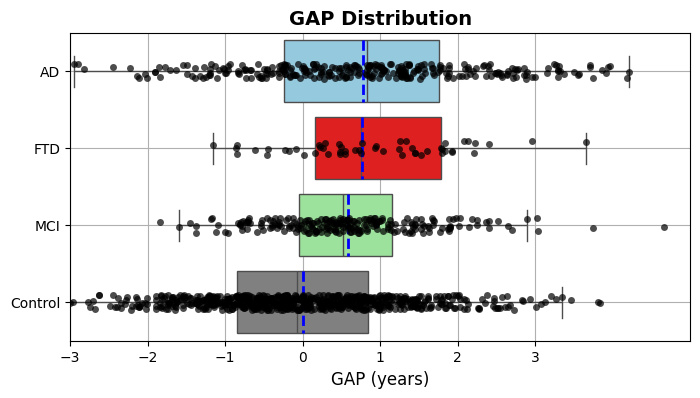

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear un DataFrame en formato largo para los errores
#corrected_gap_PD = pd.to_numeric(results_avg_PD['GAP_corrected'])
corrected_gap_AD = pd.to_numeric(results_avg_list[1]['GAP_corrected'])
corrected_gap_FTD = pd.to_numeric(results_avg_list[2]['GAP_corrected'])
corrected_gap_MCI = pd.to_numeric(results_avg_list[3]['GAP_corrected'])
corrected_gap_CN_test = pd.to_numeric(results_avg_list[0]['GAP_corrected'])

data = {
    'Error': np.concatenate([ corrected_gap_AD, corrected_gap_FTD, corrected_gap_MCI, corrected_gap_CN_test]),
    'Grupo':  ['AD'] * len(corrected_gap_AD) + ['FTD'] * len(corrected_gap_FTD) + ['MCI'] * len(corrected_gap_MCI) + ['Control'] * len(corrected_gap_CN_test)
}

df_errors = pd.DataFrame(data)

# Definir la paleta de colores personalizada
colores_personalizados = {
    'AD': 'skyblue',
    'FTD': 'red',
    'MCI': 'lightgreen',
    #'PD': 'orange',
    'Control': 'gray'
}

# Crear el diagrama de cajas y los puntos individuales en forma horizontal
plt.figure(figsize=(8, 4))

# Boxplot con la mediana (por defecto) y la media con una línea de otro color
sns.boxplot(y='Grupo', x='Error', data=df_errors, showfliers=False, palette=colores_personalizados, 
            showmeans=True, 
            meanline=True, 
            meanprops={"color": "blue", "ls": "--", "linewidth": 2})  # Líneas de la media personalizadas

# Agregar puntos individuales
sns.stripplot(y='Grupo', x='Error', data=df_errors, color='black', size=5, alpha=0.7, jitter=True)

# Título y etiquetas
plt.title('GAP Distribution', fontsize=14, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.xlabel('GAP (years)', fontsize=12)
plt.xlim(-3, 5)
plt.xticks(np.arange(-3, 4, 1))
plt.grid(True)

plt.show()
